In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
import seaborn as sns
sns.set() # set seaborn default parameters for plots
import networkx as nx
import random
import pickle
import collections
import powerlaw
# may need to install it:
# pip install powerlaw
import EoN
# may need to install it:
# pip install EoN

import os 
import sys
data_path = os.path.abspath('data')
figures_path = os.path.abspath('figures')
graphs_path = os.path.abspath('graphs')
scripts_path = os.path.abspath('scripts')
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

%load_ext autoreload
%autoreload 2

from graphs_processing import GraphProperties, SpectralClustering, construct_nodes_clusters
from epidemics import EpidemicsSimulation, EpidemicsSimulationWithControl, ControlStrategy
from control_strategies import random_airports_removal, random_neighbors_removal, \
    largest_airports_removal, largest_infected_airports_removal, largest_routes_removal
import statsmodels.api as sm
from sklearn.cluster import KMeans

## Network building

### Data loading

The description of the columns can be found in the site: https://openflights.org/data.html


In [2]:
airline_cols =["airlineID", "name", "alias", "IATA", "ICAO", "callsign", "country", "active"]
airport_cols = ["airportID", "name", "city", "country", "IATA", "ICAO", "latitude", 
                "longitude", "altitude", "timezone", "DST", "tz", "type", "source"]
routes_cols = ["airline", "airlineID", "source", "sourceID", "destination", "destinationID", 
               "codeshare", "stops", "equipment"]
plane_cols = ["name", "IATA", "ICAO"]
df_airlines = pd.read_csv('data/airlines.csv',names=airline_cols, na_values=['\\N'])
df_airports = pd.read_csv('data/airports.csv',names=airport_cols, na_values=['\\N'])
df_routes = pd.read_csv('data/routes.csv', names=routes_cols, na_values=['\\N'])
df_planes = pd.read_csv('data/planes.csv', names=plane_cols, na_values=['\\N'])

We have 4 different datasets, we need see how they relate and what kind of information is useless. The nodes in our network are clearly the airports, and we could just consider the airport dataframe but we want to exclude unconnected airports from our graph, as they are unreachable.

### Preprocessing

In [3]:
def preprocessing(df_airports, df_routes, airport_ids_to_remove=[]):
    """Preprocess the data frames.
    
    Parameters:
    -----------
    df_airports : pandas DataFrame
        The dataframe with airports data.
    df_routes : pandas DataFrame
        The dataframe with routes data.
    airport_ids_to_remove : list, optional
        The list of airport IDs to remove from df_airports. 
        This can be used to remove the airports belonging to unwanted connected components for instance.
        
    Returns:
    --------
    df_routes : pandas DataFrame
        The dataframe with routes data.
    df_airports : pandas DataFrame
        The dataframe with airports data.
    """
    # Routes dataset
    print("Number of routes   before filtering: {}".format(df_routes.shape[0]))

    ## Drop unrecognized airports
    df_routes = df_routes[~(df_routes.sourceID.isna() | df_routes.destinationID.isna())].copy()

    # Keep only first aircraft type ('equipment') when several are mentioned
    df_routes.equipment = df_routes.equipment.apply(lambda equip: str(equip)[:3])

    # Drop unrecognized aircraft types (i.e. equipment)
    df_routes = df_routes[(df_routes.equipment != 'nan')]

    # Correct three aircraft types to the most likely one letter away
    df_routes.loc[df_routes.equipment == ' 73', 'equipment'] = '733'
    df_routes.loc[df_routes.equipment == ' 77', 'equipment'] = '77W'
    df_routes.loc[df_routes.equipment == ' CN', 'equipment'] = 'CNT'

    # remove flight with same destination and source, with no stop
    df_routes = df_routes[~( (df_routes.sourceID == df_routes.destinationID) & (df_routes.stops == 0) )]
    
    # if some specific airports IDs to be removed have been input, 
    # remove all the routes containing them
    if airport_ids_to_remove: # means if airport_ids_to_remove is not empty
        df_routes = df_routes[~(df_routes.sourceID.isin(airport_ids_to_remove) | 
                                df_routes.destinationID.isin(airport_ids_to_remove))]

    print("Number of routes   after filtering:  {}".format(df_routes.shape[0]))

    # Airports dataset
    print("Number of airports before filtering: {}".format(df_airports.airportID.unique().size))

    # Change city names to lower case
    df_airports.city = df_airports.city.apply(lambda c: str(c).lower()).copy()

    # Change altitude from feet to meters
    df_airports.altitude = df_airports.altitude * 0.3048

    df_airports = df_airports[df_airports.airportID.isin(df_routes.sourceID) |
                           df_airports.airportID.isin(df_routes.destinationID)].reset_index(drop=True)
    df_airports['array_idx'] = df_airports.index

    print("Number of airports after filtering:  {}".format(df_airports.airportID.unique().size))
    
    return df_airports, df_routes

In [4]:
df_airports_pp, df_routes_pp = preprocessing(df_airports, df_routes, [])

Number of routes   before filtering: 67663
Number of routes   after filtering:  67221
Number of airports before filtering: 7698
Number of airports after filtering:  3216


### Construct Adjacency matrix

In [5]:
def compute_matrix_from_edges(row, adj_mat, sym=False):
    x, y = row['id_src'], row['id_dst']
    if((x != None) or (y != None)):
        adj_mat[x , y] += 1
        if sym:
            adj_mat[y, x] += 1

def construct_adjacency_matrices(df_airports_pp, df_routes_pp):
    """Construct 4 adjacency matrices.
    
    Parameters:
    -----------
    df_airports_pp : pandas DataFrame
        The preprocessed dataframe with airports data.
    df_routes_pp : pandas DataFrame
        The preprocessed dataframe with routes data.
        
    Returns:
    --------
    A: numpy array of shape (len(df_airports_pp), len(df_airports_pp))
        The weighted adjacency matrix.
    A_uw: numpy array of shape (len(df_airports_pp), len(df_airports_pp))
        The unweighted adjacency matrix.
    A_sym: numpy array of shape (len(df_airports_pp), len(df_airports_pp))
        The symmetrized weighted adjacency matrix.
    A_sym_uw: numpy array of shape (len(df_airports_pp), len(df_airports_pp))
        The symmetrized unweighted adjacency matrix.
    """
    # computes edges
    df_edges = df_routes.merge(df_airports_pp[['airportID', 'array_idx']], 
                         left_on="sourceID", right_on="airportID")\
                            .drop('airportID', axis=1)\
                            .rename(columns={'array_idx': 'id_src'})
    df_edges = df_edges.merge(df_airports_pp[['airportID', 'array_idx']], 
                          left_on="destinationID", right_on="airportID")\
                            .drop('airportID', axis=1)\
                            .rename(columns={'array_idx': 'id_dst'})
    
    # build adjacency matrics
    num_nodes = df_airports_pp.airportID.unique().size

    A = np.zeros((num_nodes, num_nodes))
    df_edges.apply(lambda r: compute_matrix_from_edges(r, A), axis=1);
    A_uw = ((A )> 0).astype(int)
    A_sym = A + A.T
    A_sym_uw = (A_sym > 0).astype(int)
    
    return A, A_uw, A_sym, A_sym_uw

In [6]:
A, A_uw, A_sym, A_sym_uw = \
    construct_adjacency_matrices(df_airports_pp, df_routes_pp)

We check if the initial matrix is symmetric, indicating that every flight from A to B has a corresponding return flight.

In [7]:
((A - A.T) != 0).sum()

3152

As we can see this is not the case.
Let's now briefly see how different the weighted network is from the unweighted one.

In [8]:
num_nodes = len(A)
num_edges = A_uw.sum()
num_weights = A.sum()

print(f"Number of airports: {num_nodes}")
print(f"Number of edges in the directed graph: {num_edges}")
print(f"Number of weights in the directed graph: {num_weights}")

Number of airports: 3216
Number of edges in the directed graph: 36903
Number of weights in the directed graph: 66767.0


The large difference between number of edges and number of weights means that some airports are connected by multiple flights.

## Compute properties of the initial network

In the remaining of our work, we always use the _undirected_ network.
Let's have a look at the properties of the unweighted initial network.

In [9]:
# Compute and display graph properties
g = nx.from_numpy_array(A)
g_properties = GraphProperties(g)
g_properties.compute_properties(comprehensive=True)
print(g_properties)

Computing average neighbor degree...
Computing average degree connectivity...
--------------------------
    NETWORK PROPERTIES    
--------------------------
The network has 3216 nodes and 18857 edges.
The network has 11 connected components.
The average node degree is 11.727.
The average degree squared <k^2> is 763.736.
The median degree is 3.0.
The average clustering coefficient is 0.492.
The average _neighbor_ degree is 57.271.
The average degree connectivity is 65.294.


Observations:
- There are 11 connected components: 11 isolated subnetworks.
- The average node degree is much larger than the median degree. $\langle k^2 \rangle$ is also very large. It suggests that the network is scale-free.

Now we plot the degree distribution of the weighted and the unweighted graphs.

In [10]:
airports_degree_sequence = np.sum(A, axis=1)
airports_degree_sequence_uw = np.sum(A_uw, axis=1)

Text(0, 0.5, 'Count')

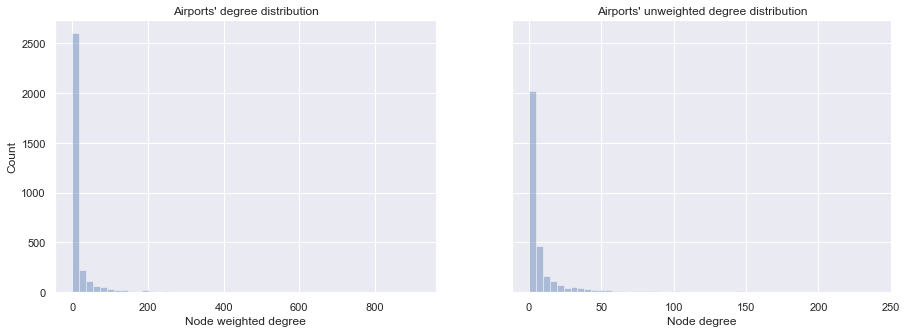

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
sns.distplot(airports_degree_sequence, kde=False, ax=axes[0])
axes[0].set_title("Airports' degree distribution")
axes[0].set_xlabel('Node weighted degree')
axes[0].set_ylabel('Count')
sns.distplot(airports_degree_sequence_uw, kde=False, ax=axes[1])
axes[1].set_title("Airports' unweighted degree distribution")
axes[1].set_xlabel('Node degree')
axes[0].set_ylabel('Count')

We can see that the distribution of airports degree follows a heavy-tailed power law.

Finally, this is how the adjacency matrix looks.

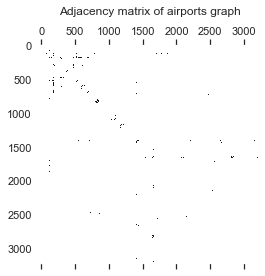

In [12]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Adjacency matrix of airports graph', pad=20)
ax.spy(A)

### Identify connected components and construct the single component network

In [13]:
# Get list of connected components
g_connected_components_list = list(nx.connected_components(g))

In [14]:
# Print sizes of each connected component
for i, cc in enumerate(g_connected_components_list):
    print('Connected component number {:02d} has {} nodes.'.format(i + 1, len(cc)))

Connected component number 01 has 3186 nodes.
Connected component number 02 has 10 nodes.
Connected component number 03 has 4 nodes.
Connected component number 04 has 4 nodes.
Connected component number 05 has 2 nodes.
Connected component number 06 has 2 nodes.
Connected component number 07 has 4 nodes.
Connected component number 08 has 1 nodes.
Connected component number 09 has 1 nodes.
Connected component number 10 has 1 nodes.
Connected component number 11 has 1 nodes.


We can see that the connected component number 01 contains almost all the nodes. We want to keep only this one for the rest of the work.

In [15]:
# Get airport IDs from minor connected components 
airport_ids_to_remove = set()
for cc in g_connected_components_list[1:]:
    cc_ids_to_remove = set(df_airports_pp.airportID[df_airports_pp.array_idx.isin(cc)])
    airport_ids_to_remove.update(cc_ids_to_remove)

In [16]:
# Compute adjacency matrices of single component graph
df_airports_sc_pp, df_routes_sc_pp = preprocessing(df_airports, df_routes, airport_ids_to_remove)
A_sc, A_sc_uw, A_sc_sym, A_sc_sym_uw = \
    construct_adjacency_matrices(df_airports_sc_pp, df_routes_sc_pp)

Number of routes   before filtering: 67663
Number of routes   after filtering:  67159
Number of airports before filtering: 7698
Number of airports after filtering:  3186


In [17]:
# Compute single component graph
gsc = nx.from_numpy_array(A_sc)

We used the software Gephi to visualize the network. Have a look at our (extended) report to see it!

## Compute (single component) network properties

In [18]:
# Compute and display single component graph properties
gsc_properties = GraphProperties(gsc)
gsc_properties.compute_properties(comprehensive=True)
print(gsc_properties)

Computing average neighbor degree...
Computing average degree connectivity...
Computing average shortest path...
Computing diameter...
--------------------------
    NETWORK PROPERTIES    
--------------------------
The network has 3186 nodes and 18832 edges.
The network has 1 connected components.
The average node degree is 11.822.
The average degree squared <k^2> is 770.877.
The median degree is 3.0.
The average clustering coefficient is 0.493.
The average _neighbor_ degree is 57.779.
The average shortest path is 3.958.
The diameter is 12.
The average degree connectivity is 65.774.


### Compute and plot $\gamma$ parameter of the scale-free network
Note that we use the unweighted graph for this computation

In [19]:
# Compute unweighted single component graph
gsc_uw = nx.from_numpy_array(A_sc_uw)

In [20]:
# Compute and display graph properties
gsc_uw_properties = GraphProperties(gsc_uw)
gsc_uw_properties.compute_properties(comprehensive=True)
print(gsc_uw_properties)

Computing average neighbor degree...
Computing average degree connectivity...
Computing average shortest path...
Computing diameter...
--------------------------
    NETWORK PROPERTIES    
--------------------------
The network has 3186 nodes and 18832 edges.
The network has 1 connected components.
The average node degree is 11.822.
The average degree squared <k^2> is 770.877.
The median degree is 3.0.
The average clustering coefficient is 0.493.
The average _neighbor_ degree is 57.779.
The average shortest path is 3.958.
The diameter is 12.
The average degree connectivity is 65.774.


In [21]:
# Fit power-law to degree distribution of the graph
gsc_degree_powerlaw = powerlaw.Fit(gsc_uw_properties.degree_sequence)

Calculating best minimal value for power law fit
/Users/jonathandoenz/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [22]:
print('The optimal value for $\gamma$ is {:.3f} $\pm$ {:.3f}'.format(gsc_degree_powerlaw.alpha, 
                                                             gsc_degree_powerlaw.sigma))

The optimal value for $\gamma$ is 1.863 $\pm$ 0.017


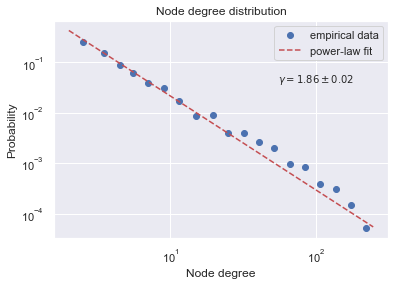

In [23]:
fig = gsc_degree_powerlaw.plot_pdf(color='b', linestyle='', marker='o', label='empirical data')
gsc_degree_powerlaw.power_law.plot_pdf(color='r', linestyle='--', ax=fig, label='power-law fit')
fig.set_title('Node degree distribution')
fig.set_xlabel('Node degree')
fig.set_ylabel('Probability')
fig.legend()
text_to_add = r'$\gamma = {:.2f} \pm {:.2f}$'.format(gsc_degree_powerlaw.alpha, gsc_degree_powerlaw.sigma)
fig.text(55, 0.04, text_to_add)
figure_path = figures_path + os.sep + 'node_degree_distribution.png'
# plt.savefig(figure_path)

### Compute distribution of edges' weights

In [24]:
routes_count_dict = collections.Counter(np.ravel(A_sc))
del routes_count_dict[0.0]
num_non_zero_entries_A_sc = (A > 0).sum()
routes_proportions_dict = {key: 100 * val / num_non_zero_entries_A_sc for key, val in routes_count_dict.items()}
sorted_routes_count_dict = collections.OrderedDict(sorted(routes_count_dict.items()))
routes_keys = [int(val) for val in sorted_routes_count_dict.keys()]
routes_values = list(sorted_routes_count_dict.values())

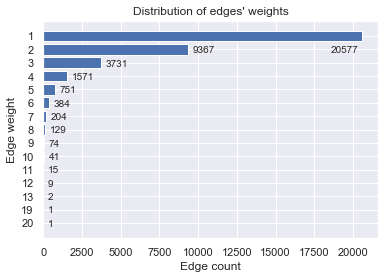

In [25]:
fig, ax = plt.subplots()
y_pos = np.arange(len(routes_values))
ax.barh(y_pos, routes_values)
ax.set_yticks(y_pos)
ax.set_yticklabels(routes_keys)
ax.invert_yaxis()
ax.set_title("Distribution of edges' weights")
ax.set_xlabel('Edge count')
ax.set_ylabel('Edge weight')
# plt.xlim(0, 22600)

for i, txt in enumerate(routes_values):
    if i == 0:
        ax.annotate(txt, (txt - 2000, i + 1.25))
    else:
        ax.annotate(txt, (txt + 300, i + 0.25))
        
figure_path = figures_path + os.sep + 'weights_distribution.png'
# plt.savefig(figure_path)

### Study the distribution of flights that are one-way _only_

We now investigate whether there are many routes (aka _pairs of airports_) for which the number of flights from airport A to airport B is different from the number of flights from B to A.

To do this, we compute the absolute difference between the number of flights from A to B versus from B to A for each pair of airport and analyze the resulting distribution.

In [26]:
flights_differences_sequence = np.ravel( np.abs(np.triu(A_sc) - np.triu(A_sc.T)) )
flights_differences_dict = collections.Counter(flights_differences_sequence)
# compute separately for value 0: when num_flights_in = num_flights_out 
# this is to avoid counting the pairs of airports for which there is no connection
non_zero_connections_mask = (A_sc_sym > 0)
zero_difference_mask = ( (np.triu(A_sc) - np.triu(A_sc.T)) == 0 )
num_same_in_out_connections = (non_zero_connections_mask & zero_difference_mask).sum()
flights_differences_dict[0.0] = num_same_in_out_connections

sorted_flights_differences_dict = collections.OrderedDict(sorted(flights_differences_dict.items()))
flights_differences_keys = [int(key) for key in sorted_flights_differences_dict]
flights_differences_values = list(sorted_flights_differences_dict.values())

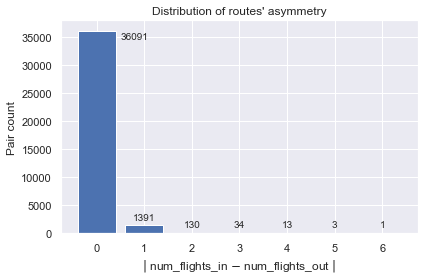

In [27]:
fig, ax = plt.subplots()
x_pos = np.arange(len(flights_differences_values))
ax.bar(x_pos, flights_differences_values)
ax.set_xticks(flights_differences_keys)
ax.set_title("Distribution of routes' asymmetry")
ax.set_xlabel(r'$|$ num_flights_in $-$ num_flights_out $|$')
ax.set_ylabel('Pair count')

for i, txt in enumerate(flights_differences_values):
    if i == 0:
        ax.annotate(txt, (i + 0.5, txt - 1500))
    else:
        ax.annotate(txt, (i, txt + 1000), ha='center')
        
plt.tight_layout()
figure_path = figures_path + os.sep + 'distribution_flights_differences.png'
# plt.savefig(figure_path)

In [28]:
num_routes = sum(flights_differences_values)
fraction_symmetric_routes = flights_differences_values[0] / num_routes

In [29]:
print('{:.1f}% of the routes are symmetric'.format(100 * fraction_symmetric_routes))

95.8% of the routes are symmetric


As the large majority of routes are symmetric, we chose to use the undirected graph for our further analyses.

## Compute Spectral Clustering (SC) and KMeans (KM)

In the following section:

`num_classes_list` contains the values of $k$ for which we compute SC and KM.

`gsc_SC_KM` is the single component graph, to which we add the attributes 
`SC_i` and `KM_i` denoting the predicted label of respectively Spectral Clustering and KMeans with parameter $k=$`i`.

In [30]:
def build_SC_KM_graph(gsc, num_classes_list, df_airports_sc_pp, write_to_file=False):
    """Compute graph with spectral clustering and K-means assignments for a list of values for parameter k. 
    
    Parameters:
    -----------
    gsc : networkx Graph object
        The input graph.
    num_classes_list : list
        The list of values of parameter k for which to compute spectral clustering and k-means.
    df_airports_sc_pp : pandas DataFrame
        The latitude and longitude coordinates of the nodes (airports) of the graph as (node_id: (latitude, longitude)).
    write_to_file : boolean, optional
        If true, write the output graph to a .gexf file that can be read by the Gephi software.
        
    Returns:
    --------
    gsc_SC_KM : networkx Graph object
        The input graph with node attributes from:
        - all attributes in the df_airports_sc_pp dataframe
        - SC_i and KM_i representing the assignments
        of respectively spectral clustering and k-means with parameter k=i, 
        for all i in num_classes_list.
    """
    if gsc.number_of_nodes() != len(df_airports_sc_pp):
        raise ValueError('The graph and the airport dataframe must be of the same size.')
        
    # we use the latitude, longitude coordinates for KMeans
    df_coordinates = df_airports_sc_pp[['array_idx', 'latitude', 'longitude']].sort_values(by='array_idx', ascending=True).copy()

    # construct new graph and add airport attributes to nodes
    gsc_SC_KM = gsc.copy()
    airports_attributes_dict = df_airports_sc_pp.to_dict()
    for key in airports_attributes_dict.keys():
        nx.set_node_attributes(gsc_SC_KM, airports_attributes_dict[key], key)
    
    # compute Laplacian and its eigendecomposition of the graph
    SC_gsc_n = SpectralClustering(gsc_SC_KM)
    SC_gsc_n.fit()

    for n_classes in num_classes_list:
        if n_classes % 5 == 0:
            print('Start computing for n = {}'.format(n_classes))
    #     print('Start Spectral Clustering')
        SC_gsc_n.predict(n_classes)
        SC_y_pred_dict = {i: v for i, v in enumerate(SC_gsc_n.y_pred)}
        nx.set_node_attributes(gsc_SC_KM, name='SC_' + str(n_classes).zfill(2), values=SC_y_pred_dict)

    #     print('Start KMeans')
        KM_y_pred = KMeans(n_clusters=n_classes).fit_predict(df_coordinates[['latitude', 'longitude']])
        KM_y_pred_dict = {i: v for i, v in enumerate(KM_y_pred)}
        nx.set_node_attributes(gsc_SC_KM, name='KM_' + str(n_classes).zfill(2), values=KM_y_pred_dict)

    if write_to_file:
        # write graph into a file that can be read by the Gephi software
        graph_filepath = graphs_path + os.sep + 'gsc_SC_KM_' + str(num_classes_list[0]).zfill(2) + \
        '_to_' + str(num_classes_list[-1]).zfill(2) + '.gexf'
        nx.write_gexf(gsc_SC_KM, graph_filepath)
    
    return gsc_SC_KM

In [31]:
num_classes_list = list(range(2, 81))
gsc_SC_KM = build_SC_KM_graph(gsc, num_classes_list, df_airports_sc_pp, write_to_file=False)

Compute laplacian matrix of graph...
Compute eigenvalues and eigenvectors of laplacian matrix...
Start computing for n = 5
Start computing for n = 10
Start computing for n = 15
Start computing for n = 20
Start computing for n = 25
Start computing for n = 30
Start computing for n = 35
Start computing for n = 40
Start computing for n = 45
Start computing for n = 50
Start computing for n = 55
Start computing for n = 60
Start computing for n = 65
Start computing for n = 70
Start computing for n = 75
Start computing for n = 80


We used the software Gephi to visualize the clusters. Have a look at our report to see them!

We save this graph so we can run the epidemics simulations without having to recompute the single component graph and the different clusterings each time

In [32]:
with open(graphs_path + os.sep + 'gsc_SC_KM_2_to_80.pkl', 'wb') as f:
    pickle.dump(gsc_SC_KM, f)

<a id='clusters'></a>
### Show proportion of nodes from each cluster
Let's compare the distribution of nodes in the clusters from Spectral Clustering (SC), and from KMeans (KM).

In [33]:
def plot_cluster_sizes(gsc_SC_KM, clustering_method, num_classes_list):
    plt.figure(figsize=(15, 3))

    for k in num_classes_list:
        nodes_clusters = construct_nodes_clusters(gsc_SC_KM, {clustering_method: k})
        sorted_cluster_ids_asc = sorted(nodes_clusters[clustering_method]['cluster_length_dict'], 
               key=nodes_clusters[clustering_method]['cluster_length_dict'].get)
        bottom = 0.
        for cluster_id in sorted_cluster_ids_asc[::-1]:
            num_nodes = nodes_clusters[clustering_method]['cluster_length_dict'][cluster_id]
            plt.bar(k, num_nodes, bottom=bottom, width = 0.85, edgecolor='white')
            bottom += num_nodes
            
    plt.xticks(num_classes_list, num_classes_list)
    plt.title(r'Number of nodes per {} cluster for different clustering sizes $k$'.format(clustering_method))
    plt.xlabel(r'Number of clusters $k$')
    plt.ylabel('Number of nodes')
    plt.tight_layout()

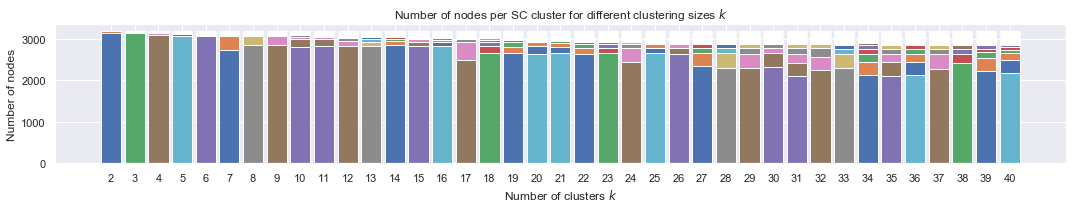

In [34]:
clustering_method = 'SC'
k_from, k_to = 2, 41
plot_cluster_sizes(gsc_SC_KM, clustering_method, list(range(k_from, k_to)))
figure_path = figures_path + os.sep + \
    'cluster_sizes_{}_{:02d}_to_{:02d}.png'.format(clustering_method, k_from, k_to)
# plt.savefig(figure_path)

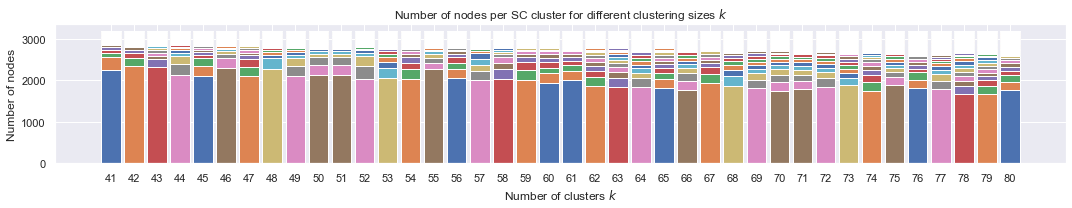

In [35]:
clustering_method = 'SC'
k_from, k_to = 41, 81
plot_cluster_sizes(gsc_SC_KM, clustering_method, list(range(k_from, k_to)))
figure_path = figures_path + os.sep + \
    'cluster_sizes_{}_{:02d}_to_{:02d}.png'.format(clustering_method, k_from, k_to)
# plt.savefig(figure_path)

We can see that in the case of Spectral Clustering, there is always one cluster which contains the majority of the nodes even when the number of clusters present $k$ is large.

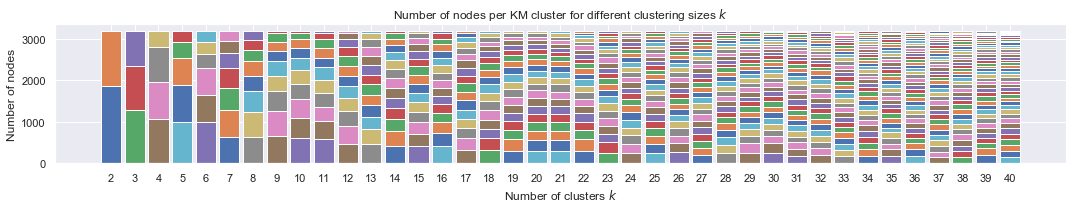

In [36]:
clustering_method = 'KM'
k_from, k_to = 2, 41
plot_cluster_sizes(gsc_SC_KM, clustering_method, list(range(k_from, k_to)))
figure_path = figures_path + os.sep + \
    'cluster_sizes_{}_{:02d}_to_{:02d}.png'.format(clustering_method, k_from, k_to)
# plt.savefig(figure_path)

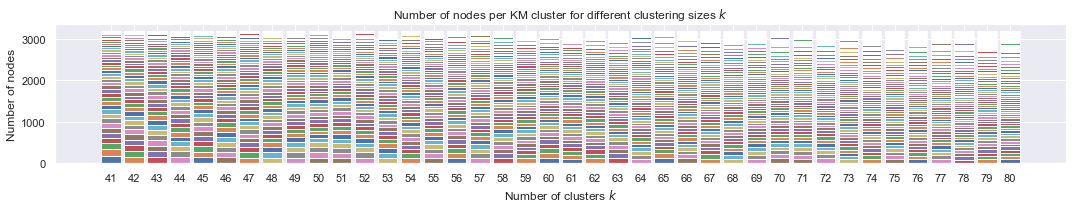

In [37]:
clustering_method = 'KM'
k_from, k_to = 41, 81
plot_cluster_sizes(gsc_SC_KM, clustering_method, list(range(k_from, k_to)))
figure_path = figures_path + os.sep + \
    'cluster_sizes_{}_{:02d}_to_{:02d}.png'.format(clustering_method, k_from, k_to)
# plt.savefig(figure_path)

By contrast, KMeans clustering produces balanced sized clusters for any value of the parameter $k$.

## Epidemics simulation

We now run simulations of the epidemics model _Susceptible-Infected-Susceptible_ (SIS) on our airports graph using the [Epidemics on Networks (EoN)](#https://epidemicsonnetworks.readthedocs.io/en/latest/) Python library.

If you just want to run this part, you can simply load the airports graph by running the next cell.

In [38]:
with open(graphs_path + os.sep + 'gsc_SC_KM_2_to_80.pkl', 'rb') as f:
    gsc_SC_KM = pickle.load(f)

### The dynamics of the spread depends on the degree of the initially infected airport

In [39]:
degree_dict = {n: d for n, d in gsc_SC_KM.degree()}
node_degree_tuples_list = list(degree_dict.items())
ordered_degree_list = [(n, d) for n, d in sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)]

We chose the following airports ids as initial infected airport from `ordered_degree_list`:

In [40]:
node_highest_degree_tuple = (282, 248) # Amsterdam Airport Schiphol, Netherlands
# node_high_degree_tuple = (1478, 133) # Hong Kong International Airport, Hong Kong
node_lowest_degree_tuple = (9, 1) # Thule Air Base', Greenland
node_hardest_to_reach_degree_tuple = (2304, 1) # Peawanuck, Ontario, Canada

# the following were randomly chosen
random_node_degree_tuples_list = [(168, 1), (23, 2), (1575, 6)]

In [41]:
def epidemics_simulation_factory_initial_infecteds(initial_infecteds):
    # Simulation parameters
    cluster_method_and_size_dict = {'SC': 5, 
                                    'KM': 5}
    method = EoN.fast_SIS
    R0 = 2.5
    gamma = 0.01
    tau = R0 * gamma
    num_simulations = 4
    tmin = 0
    tmax = 100
    transmission_weight = 'weight'
    sim_kwargs = {'pos': None} # it gets computed automatically in an EpidemicsSimulation instance
    epidemics_simulation_kwargs = {
        'tau': tau, 
        'gamma': gamma, 
        'initial_infecteds': initial_infecteds,
        'tmin': tmin,
        'tmax': tmax,
        'num_simulations': num_simulations,
        'transmission_weight': transmission_weight,
        'sim_kwargs': sim_kwargs,
        'compute_average': False}

    epidemics_simulation = EpidemicsSimulation(gsc_SC_KM.copy(), method, epidemics_simulation_kwargs, cluster_method_and_size_dict)
    epidemics_simulation.run()
    print(epidemics_simulation)
    epidemics_simulation.print_summary()
    fig, ax = plt.subplots(1, 1)
    epidemics_simulation.plot_time_series(ax)
    
    return epidemics_simulation

-----------------------------
    SIMULATION PARAMETERS    
-----------------------------
method: fast_SIS
tau = 0.025
gamma = 0.01
tmax = 100
number of simulations = 4

Initial infected airports:
- node_id = 282, name = Amsterdam Airport Schiphol, degree = 248

Clustering methods:
- cluster method: SC, cluster size k = 5
- cluster method: KM, cluster size k = 5
-------------------------
   Simulations summary   
-------------------------
Number of simulations = 4
Average (std) number of airports infecteds at time 100 = 2777.2 (6.3)


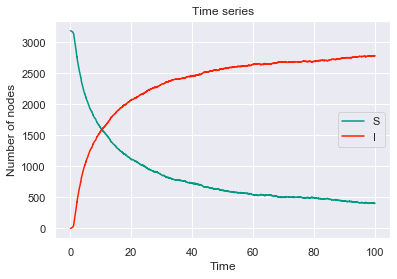

In [42]:
initial_infecteds = [node_highest_degree_tuple[0]]
episim_highest_degree_initial_infected = epidemics_simulation_factory_initial_infecteds(initial_infecteds)

When the initially infected airport is a hub, i.e. has many connections with other airports, the epidemics spreads directly and very quickly as can be seen from the large initial slope of the curves.

-----------------------------
    SIMULATION PARAMETERS    
-----------------------------
method: fast_SIS
tau = 0.025
gamma = 0.01
tmax = 100
number of simulations = 4

Initial infected airports:
- node_id = 1575, name = Sibu Airport, degree = 6

Clustering methods:
- cluster method: SC, cluster size k = 5
- cluster method: KM, cluster size k = 5
-------------------------
   Simulations summary   
-------------------------
Number of simulations = 4
Average (std) number of airports infecteds at time 100 = 2074.0 (1197.5)


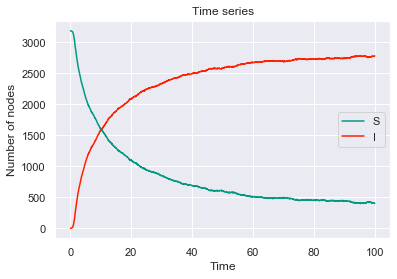

In [43]:
initial_infecteds = [random_node_degree_tuples_list[2][0]]
episim_degree_6_initial_infected = epidemics_simulation_factory_initial_infecteds(initial_infecteds)

For an initially infected airport connected to 6 other airports (degree 6), one can see an initial period where the epidemics is contained in a small number of airports. Then we observe a similar pattern as the simulation starting from a hub. 
The transition between the two periods is marked by the contamination of a hub.

-----------------------------
    SIMULATION PARAMETERS    
-----------------------------
method: fast_SIS
tau = 0.025
gamma = 0.01
tmax = 100
number of simulations = 4

Initial infected airports:
- node_id = 23, name = Nanaimo Airport, degree = 2

Clustering methods:
- cluster method: SC, cluster size k = 5
- cluster method: KM, cluster size k = 5
-------------------------
   Simulations summary   
-------------------------
Number of simulations = 4
Average (std) number of airports infecteds at time 100 = 2067.2 (1193.7)


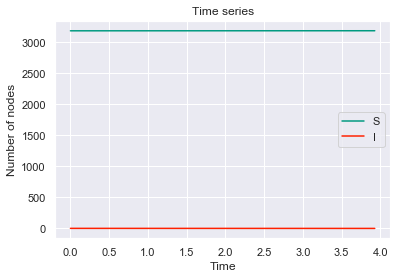

In [44]:
initial_infecteds = [random_node_degree_tuples_list[1][0]]
episim_degree_2_initial_infected = epidemics_simulation_factory_initial_infecteds(initial_infecteds)

For an initially infected airport of degree 2, we see that the period before the contamination of a hub is longer than for an initially infected airport of degree 6.

-----------------------------
    SIMULATION PARAMETERS    
-----------------------------
method: fast_SIS
tau = 0.025
gamma = 0.01
tmax = 100
number of simulations = 4

Initial infected airports:
- node_id = 9, name = Thule Air Base, degree = 1

Clustering methods:
- cluster method: SC, cluster size k = 5
- cluster method: KM, cluster size k = 5
-------------------------
   Simulations summary   
-------------------------
Number of simulations = 4
Average (std) number of airports infecteds at time 100 = 1016.8 (1110.7)


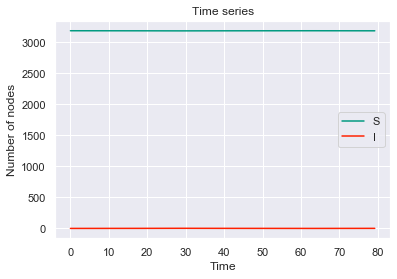

In [45]:
initial_infecteds = [node_lowest_degree_tuple[0]]
episim_degree_1_initial_infected = epidemics_simulation_factory_initial_infecteds(initial_infecteds)

The period pre hub-contamination can be long as seen with the previous simulation starting from an airport with degree 1.

-----------------------------
    SIMULATION PARAMETERS    
-----------------------------
method: fast_SIS
tau = 0.025
gamma = 0.01
tmax = 100
number of simulations = 4

Initial infected airports:
- node_id = 2304, name = Peawanuck Airport, degree = 1

Clustering methods:
- cluster method: SC, cluster size k = 5
- cluster method: KM, cluster size k = 5
-------------------------
   Simulations summary   
-------------------------
Number of simulations = 4
Average (std) number of airports infecteds at time 100 = 1.2 (1.1)


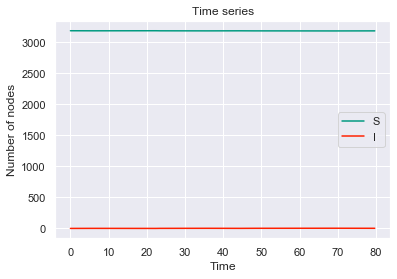

In [46]:
initial_infecteds = [node_hardest_to_reach_degree_tuple[0]]
episim_hardest_to_reach_initial_infected = epidemics_simulation_factory_initial_infecteds(initial_infecteds)

The only way that the spread of the modeled epidemics never becomes widespread is if the initially infected airport is sufficiently remote, i.e. has degree 1 and his neighbor has few connections. 
This is the case of Peawanuck Airport, which is the initially infected airport in the last simulation.
Peawanuck airport is 6 flights away from the closest international airport and can be considered as one of the remotest airports in the dataset.

### Study infection from the clusters perspective

From now on, we use the _Hong Kong International Airport_ as only initially infected airport.
We believe that the likelihood of it being the initially infected airport in a real-world scenario is very high. Here are a few reasons supporting this claim.
- Hong Kong airport is a hub with 133 connections 
- The city is highly and densely populated with a population of 7.48 million and a density of 6,777 people per km$^2$
- Southern China was the cradle of the [SARS](https://en.wikipedia.org/wiki/Severe_acute_respiratory_syndrome) epidemics in 2002 and the [Black Death](https://en.wikipedia.org/wiki/Black_Death) in the 14th century

Side note for the cinephiles: it has also been chosen as the origin of an epidemic in the movie [Contagion]( https://www.imdb.com/title/tt1598778/).

Computing average and std over the runs...
-----------------------------
    SIMULATION PARAMETERS    
-----------------------------
method: fast_SIS
tau = 0.025
gamma = 0.01
tmax = 100
number of simulations = 4

Initial infected airports:
- node_id = 1478, name = Hong Kong International Airport, degree = 133

Clustering methods:
- cluster method: SC, cluster size k = 5
- cluster method: KM, cluster size k = 5
-------------------------
   Simulations summary   
-------------------------
Number of simulations = 4
Average (std) number of airports infecteds at time 100 = 2746.0 (11.4)


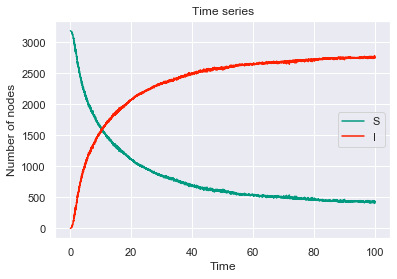

In [47]:
# Simulation parameters
cluster_method_and_size_dict = {'SC': 5, 
                                'KM': 5}
method = EoN.fast_SIS
R0 = 2.5
gamma = 0.01
tau = R0 * gamma
initial_infecteds = [1478]
num_simulations = 4
tmin = 0
tmax = 100
transmission_weight = 'weight'
sim_kwargs = {'pos': None} # it gets computed automatically in an EpidemicsSimulation instance
epidemics_simulation_kwargs = {
    'tau': tau, 
    'gamma': gamma, 
    'initial_infecteds': initial_infecteds,
    'tmin': tmin,
    'tmax': tmax,
    'num_simulations': num_simulations,
    'transmission_weight': transmission_weight,
    'sim_kwargs': sim_kwargs}

epidemics_simulation = EpidemicsSimulation(gsc_SC_KM, method, epidemics_simulation_kwargs, cluster_method_and_size_dict)
epidemics_simulation.run()
print(epidemics_simulation)
epidemics_simulation.print_summary()
fig, ax = plt.subplots(1, 1)
epidemics_simulation.plot_time_series(ax)

Let's look at the infection of the clusters obtained by spectral clustering (SC) and Kmeans clustering (KM).

In the following plots, the solid lines are the average time series of the proportion of nodes from a cluster being infected. The light coloring around the solid lines represent the standard error of the mean.

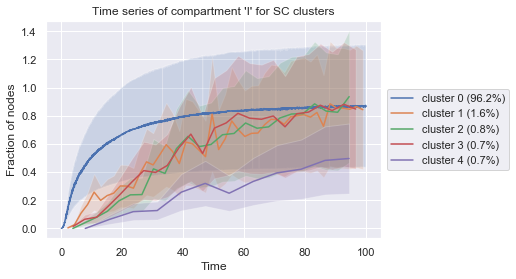

In [48]:
clustering_method = 'SC'
compartment = 'I'
fig, ax = plt.subplots(1, 1)
epidemics_simulation.plot_clusters_time_series(ax, clustering_method, compartment)

As noted in the [clustering section](#clusters), spectral clustering led to one large cluster comprising the majority of the nodes, the other clusters containing a negligible fraction of nodes compared to it.

We can see that the largest cluster is infected before the other ones.

Let's look at the results using KMeans clustering now.

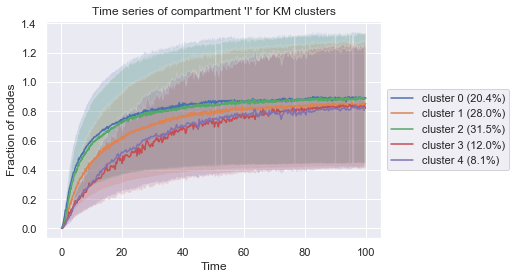

In [49]:
clustering_method = 'KM'
compartment = 'I'
fig, ax = plt.subplots(1, 1)
epidemics_simulation.plot_clusters_time_series(ax, clustering_method, compartment)

The results are cleaner for KMeans due to the balanced sizes of the clusters.
Here we can better observe that the larger the cluster is, the earlier its contamination and the quicker the spread happens within the cluster.

## Epidemics with control strategies

Presentation of the control strategies available:

In [50]:
control_strategies = [
    random_airports_removal,
    random_neighbors_removal,
    largest_airports_removal,
    largest_infected_airports_removal,
    largest_routes_removal]

for cs in control_strategies:
    print('- {}'.format(cs.__name__))
    print(cs.__doc__)
    print()

- random_airports_removal
Remove random nodes (airports) of the graph.

- random_neighbors_removal
Remove random neighbor of random nodes (airports) of the graph.

- largest_airports_removal
Remove nodes (airports) with the highest degree (number of connections).

- largest_infected_airports_removal
Remove infected nodes (airports) with the highest degree (number of connections).

- largest_routes_removal
Remove edges (routes) with the highest weights (number of flights).



We first show the time series of the number of infected/susceptible nodes over time starting from an initial infection of Hong Kong international airport and applying each control strategy at $t=40$.

In [51]:
def epidemics_simulation_factory_control_strategies(control_strategy, time_of_treatment, print_simulation_params=False):
    # Simulation parameters
    cluster_method_and_size_dict = {'SC': 5, 
                                    'KM': 5}
    method = EoN.fast_SIS
    R0 = 2.5
    gamma = 0.01
    tau = R0 * gamma
    initial_infecteds = [1478] # only infected airport is Hong-Kong International Airport at beginning of simulation
    num_simulations = 4
    tmin = 0
    tmax = 100
    transmission_weight = 'weight'
    sim_kwargs = {'pos': None} # it gets computed automatically in an EpidemicsSimulation instance
    epidemics_simulation_kwargs = {
        'tau': tau, 
        'gamma': gamma, 
        'initial_infecteds': initial_infecteds,
        'tmax': tmax,
        'num_simulations': num_simulations,
        'transmission_weight': transmission_weight,
        'sim_kwargs': sim_kwargs,
        'compute_average': False}

    epidemics_simulation_with_control = EpidemicsSimulationWithControl(gsc_SC_KM.copy(), method, 
                                                                       epidemics_simulation_kwargs, 
                                                                       control_strategy, 
                                                                       time_of_treatment,
                                                                       cluster_method_and_size_dict,
                                                                       verbose=False)
    epidemics_simulation_with_control.run()
    if print_simulation_params:
        print(epidemics_simulation_with_control)
        print()
    print(control_strategy)
    print()
    epidemics_simulation_with_control.print_summary()
    fig, ax = plt.subplots(1, 1)
    epidemics_simulation_with_control.plot_time_series(ax)
    
    return epidemics_simulation_with_control

-----------------------------
    SIMULATION PARAMETERS    
-----------------------------
method: fast_SIS
tau = 0.025
gamma = 0.01
tmax = 40
number of simulations = 4

Initial infected airports:
- node_id = 1478, name = Hong Kong International Airport, degree = 133

Clustering methods:
- cluster method: SC, cluster size k = 5
- cluster method: KM, cluster size k = 5

Control strategy
----------------
method: random_airports_removal
nodes_percentage_to_treat: 20
time of treatment: 40

Control strategy
----------------
method: random_airports_removal
nodes_percentage_to_treat: 20

--------------------------------------
   Simulations with control summary   
--------------------------------------
Number of simulations = 4
Number of airports removed = 637
Average (std) number of airports infected at time 100 = 2095.5 (29.6)


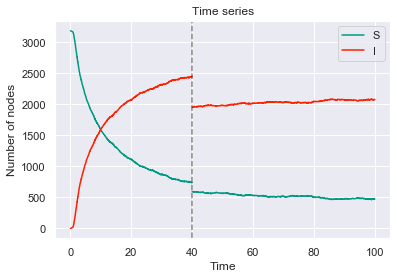

In [52]:
# Control strategy arguments:
control_method = random_airports_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
time_of_treatment = 40
control_strategy = ControlStrategy(control_method, control_method_kwargs)

episim_random_airports_removal = epidemics_simulation_factory_control_strategies(control_strategy, time_of_treatment, True)

Control strategy
----------------
method: random_neighbors_removal
nodes_percentage_to_treat: 20

--------------------------------------
   Simulations with control summary   
--------------------------------------
Number of simulations = 4
Number of airports removed = 637
Average (std) number of airports infected at time 100 = 1850.2 (19.8)


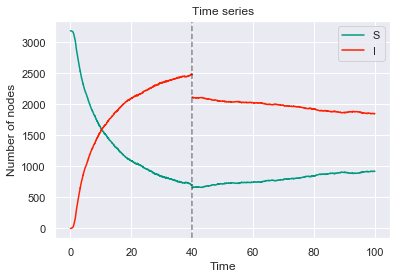

In [53]:
# Control strategy arguments:
control_method = random_neighbors_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
time_of_treatment = 40
control_strategy = ControlStrategy(control_method, control_method_kwargs)

episim_random_neighbors_removal = epidemics_simulation_factory_control_strategies(control_strategy, time_of_treatment)

Control strategy
----------------
method: largest_airports_removal
nodes_percentage_to_treat: 20

--------------------------------------
   Simulations with control summary   
--------------------------------------
Number of simulations = 4
Number of airports removed = 637
Average (std) number of airports infected at time 100 = 1397.5 (12.4)


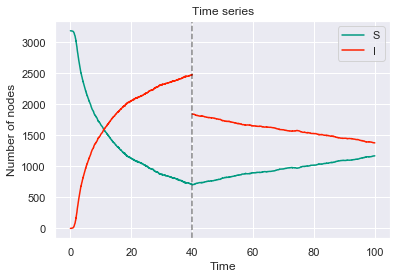

In [54]:
# Control strategy arguments:
control_method = largest_airports_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
time_of_treatment = 40
control_strategy = ControlStrategy(control_method, control_method_kwargs)

episim_largest_airports_removal = epidemics_simulation_factory_control_strategies(control_strategy, time_of_treatment)

Control strategy
----------------
method: largest_infected_airports_removal
nodes_percentage_to_treat: 20

--------------------------------------
   Simulations with control summary   
--------------------------------------
Number of simulations = 4
Number of airports removed = 637
Average (std) number of airports infected at time 100 = 1397.0 (14.2)


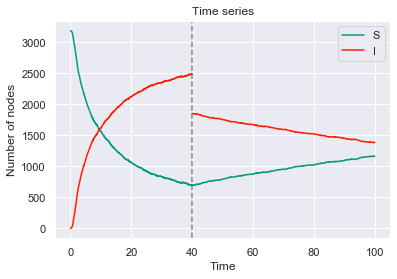

In [55]:
# Control strategy arguments:
control_method = largest_infected_airports_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
time_of_treatment = 40
control_strategy = ControlStrategy(control_method, control_method_kwargs)

episim_largest_infected_airports_removal = epidemics_simulation_factory_control_strategies(control_strategy, time_of_treatment)

Control strategy
----------------
method: largest_routes_removal
edges_percentage_to_treat: 45

--------------------------------------
   Simulations with control summary   
--------------------------------------
Number of simulations = 4
Number of routes removed = 8474
Average (std) number of airports infected at time 100 = 2471.0 (24.2)


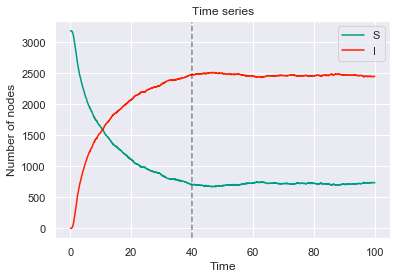

In [56]:
# Control strategy arguments:
control_method = largest_routes_removal
control_method_kwargs = {'edges_percentage_to_treat': 45}
time_of_treatment = 40
control_strategy = ControlStrategy(control_method, control_method_kwargs)

episim_largest_routes_removal = epidemics_simulation_factory_control_strategies(control_strategy, time_of_treatment)

Let's look at the results of all of the control strategies together to compare them.

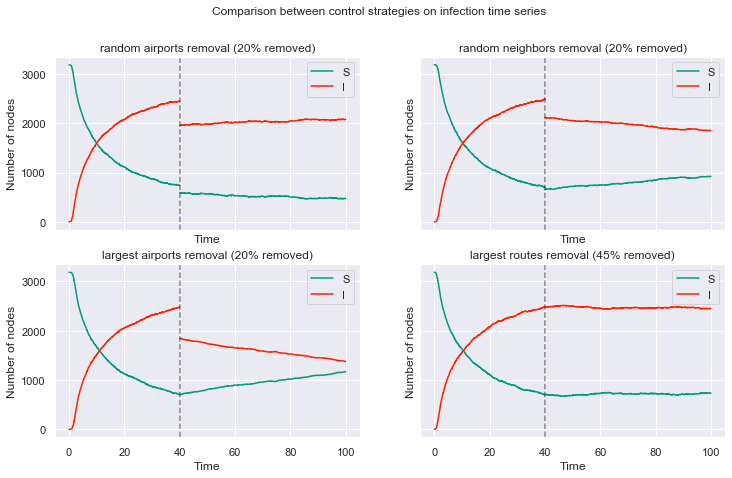

In [57]:
# gather treatment infos
random_airports_perc = episim_random_airports_removal.treatment_info_list[0]['nodes_percentage_to_treat']
random_neighbors_perc = episim_random_neighbors_removal.treatment_info_list[0]['nodes_percentage_to_treat']
largest_airports_perc = episim_largest_airports_removal.treatment_info_list[0]['nodes_percentage_to_treat']
largest_routes_perc = episim_largest_routes_removal.treatment_info_list[0]['edges_percentage_to_treat']

# plot
fig, f_axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 7), sharex=True, sharey=True)
episim_random_airports_removal.plot_time_series(f_axes[0, 0])
f_axes[0, 0].set_title('random airports removal ({}% removed)'.format(random_airports_perc))
episim_random_neighbors_removal.plot_time_series(f_axes[0, 1])
f_axes[0, 1].set_title('random neighbors removal ({}% removed)'.format(random_neighbors_perc))
episim_largest_airports_removal.plot_time_series(f_axes[1, 0])
f_axes[1, 0].set_title('largest airports removal ({}% removed)'.format(largest_airports_perc))
episim_largest_routes_removal.plot_time_series(f_axes[1, 1])
f_axes[1, 1].set_title('largest routes removal ({}% removed)'.format(largest_routes_perc))
fig.suptitle('Comparison between control strategies on infection time series')
figure_path = figures_path + os.sep + 'control_strats_comparison_time_series.png'
# plt.savefig(figure_path)

Observations:
- Random neighbors removal is more efficient than random airports removal as expected from the friendship paradox. We notice that most of the random neighbors nodes that have been selected turned out to be infected nodes.
- Largest airports removal is the most efficient control strategy but it is also the most disruptive of the aerial network: shutting down the biggest airports rapidly breaks the unique network into several isolated networks.
- Largest routes removal requires to remove about 45 % of the routes for the epidemics to stay constant and not grow after the treatment.

### Long term impact of time of treatment on number of infected airports


We now investigate the impact of the time at which we apply a control strategy. Is acting early primordial to stabilize the spread for all control strategies? Are some strategies more sensitive to it? These are the questions we try to answer here.

We run a set of simulations for different treatment-times between 10 and 95.
For each treatment-time's set of simulations, we compute the average number of airports being infected at the end of the simulation (time = 100).

The plot of the number of infected airports with respect to the treatment-time gives insight to the sensitivity of each method to the time at which the control strategy is applied.

In [58]:
def epidemics_simulation_factory_time_of_treatment(gsc_SC_KM, control_strategy, time_of_treatment_list):
    avg_std_tuples_list = []
    for time_of_treatment in time_of_treatment_list:
        cluster_method_and_size_dict = {'SC': 5, 
                                        'KM': 5}
        method = EoN.fast_SIS
        # R0 = 2.5 = tau / gamma
        tau = 0.005
        gamma = 0.002
        initial_infecteds = [1478] # only infected airport is Hong-Kong International Airport at beginning of simulation
        num_simulations = 4
        tmin = 0
        tmax = 100
        transmission_weight = 'weight'
        sim_kwargs = {'pos': None} # it gets computed automatically in an EpidemicsSimulation instance
        epidemics_simulation_kwargs = {
            'tau': tau, 
            'gamma': gamma, 
            'initial_infecteds': initial_infecteds,
            'tmax': tmax,
            'num_simulations': num_simulations,
            'transmission_weight': transmission_weight,
            'sim_kwargs': sim_kwargs,
            'compute_average': False}

        # Control strategy arguments:
        control_strategy = ControlStrategy(control_method, control_method_kwargs)
        epidemics_simulation_with_control = EpidemicsSimulationWithControl(gsc_SC_KM.copy(), method, 
                                                                           epidemics_simulation_kwargs, 
                                                                           control_strategy, 
                                                                           time_of_treatment,
                                                                           cluster_method_and_size_dict,
                                                                           verbose=False)
        epidemics_simulation_with_control.run()
        avg_std_tuples_list.append((epidemics_simulation_with_control.average_final_number_of_infecteds,
                                   epidemics_simulation_with_control.std_final_number_of_infecteds))
        
    return avg_std_tuples_list

In [59]:
def perform_linear_regression(time_of_treatment_list, avgs):
    x = np.array(time_of_treatment_list)
    y = np.array(avgs)
    x = sm.add_constant(x)
    model = sm.OLS(y, x)
    results = model.fit()
    
    return results

def plot_num_infected_vs_time_of_treatment(ax, time_of_treatment_list, num_infected_list, control_strategy, with_linear_regression=True):
    avgs = [tuple_[0] for tuple_ in num_infected_list]
    stds = [tuple_[1] for tuple_ in num_infected_list]
    sns.regplot(x=time_of_treatment_list, y=avgs, ax=ax)
    
    if with_linear_regression:
        # perform linear regression
        results = perform_linear_regression(time_of_treatment_list, avgs)
        
        # make annotation with linear regression results
        linreg_strings = [
            'Linear regression:',
            'slope = {:.1f} ({:.1f})'.format(results.params[1], results.bse[1]),
            'y-intercept = {:.0f} ({:.0f})'.format(results.params[0], results.bse[0]),
            r'$R^2$ adj = {:.3f}'.format(results.rsquared_adj)]
        text_string = os.linesep.join(linreg_strings)
        ax.annotate(text_string, (60, 100))
    
    # plot parameters
    ax.grid(True)
    ax.set_xticks([20, 40, 60, 80])
    ax.set_xlim([0, 100])
    ax.set_ylim(bottom=0, top=2200)
    ax.set_xlabel('Time of treatment')
    ax.set_ylabel('Number of airports infected')

In [60]:
# time_of_treatment_list = [20, 40, 60, 80]
time_of_treatment_list = list(range(10, 100, 5))
control_method = random_airports_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
control_strategy_rar = ControlStrategy(control_method, control_method_kwargs)
num_infected_rar_list = epidemics_simulation_factory_time_of_treatment(gsc_SC_KM, control_strategy_rar, time_of_treatment_list)

control_method = random_neighbors_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
control_strategy_rnr = ControlStrategy(control_method, control_method_kwargs)
num_infected_rnr_list = epidemics_simulation_factory_time_of_treatment(gsc_SC_KM, control_strategy_rnr, time_of_treatment_list)

control_method = largest_airports_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
control_strategy_lar = ControlStrategy(control_method, control_method_kwargs)
num_infected_lar_list = epidemics_simulation_factory_time_of_treatment(gsc_SC_KM, control_strategy_lar, time_of_treatment_list)

control_method = largest_infected_airports_removal
control_method_kwargs = {'nodes_percentage_to_treat': 20}
control_strategy_lia = ControlStrategy(control_method, control_method_kwargs)
num_infected_lia_list = epidemics_simulation_factory_time_of_treatment(gsc_SC_KM, control_strategy_lia, time_of_treatment_list)

control_method = largest_routes_removal
control_method_kwargs = {'edges_percentage_to_treat': 45}
control_strategy_lrr = ControlStrategy(control_method, control_method_kwargs)
num_infected_lrr_list = epidemics_simulation_factory_time_of_treatment(gsc_SC_KM, control_strategy_lrr, time_of_treatment_list)


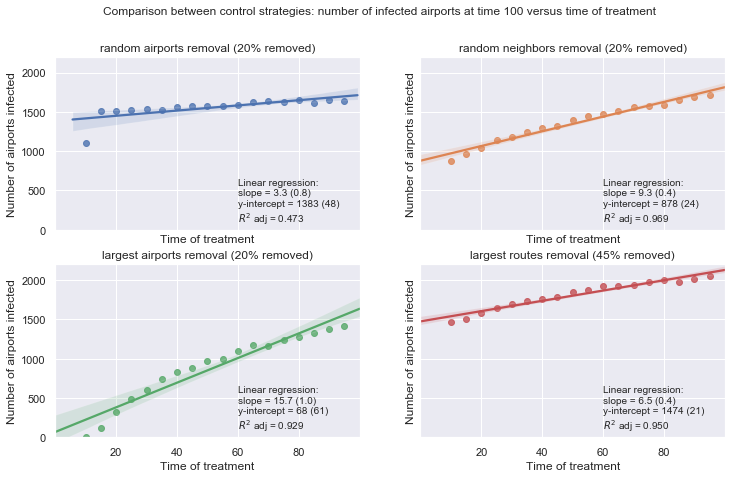

In [61]:
# gather treatment infos
rar_perc = control_strategy_rar.method_kwargs['nodes_percentage_to_treat']
rnr_perc = control_strategy_rnr.method_kwargs['nodes_percentage_to_treat']
lar_perc = control_strategy_lar.method_kwargs['nodes_percentage_to_treat']
lia_perc = control_strategy_lia.method_kwargs['nodes_percentage_to_treat']
lrr_perc = control_strategy_lrr.method_kwargs['edges_percentage_to_treat']

# plot
fig, f_axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 7), sharex=True, sharey=True)
plot_num_infected_vs_time_of_treatment(f_axes[0, 0], time_of_treatment_list, num_infected_rar_list, control_strategy_rar)
f_axes[0, 0].set_title('random airports removal ({}% removed)'.format(rar_perc))
plot_num_infected_vs_time_of_treatment(f_axes[0, 1], time_of_treatment_list, num_infected_rnr_list, control_strategy_rnr)
f_axes[0, 1].set_title('random neighbors removal ({}% removed)'.format(rnr_perc))
plot_num_infected_vs_time_of_treatment(f_axes[1, 0], time_of_treatment_list, num_infected_lia_list, control_strategy_lia)
f_axes[1, 0].set_title('largest airports removal ({}% removed)'.format(lar_perc))
plot_num_infected_vs_time_of_treatment(f_axes[1, 1], time_of_treatment_list, num_infected_lrr_list, control_strategy_lrr)
f_axes[1, 1].set_title('largest routes removal ({}% removed)'.format(lrr_perc))
fig.suptitle('Comparison between control strategies: number of infected airports at time 100 versus time of treatment')
figure_path = figures_path + os.sep + 'control_strats_comparison_time_of_treatment.png'
# plt.savefig(figure_path)

Observations:
- _Random airports removal_ is quite ineffective (large number of infected airports for smallest time of treatment) and not sensitive to the time at which the treatment is applied (small differences of number of infected for all the times of treatment)
- Choosing a random neighbor of a random airport is more effective than just choosing a random airport as can be seen from the improved performance of _random neighbors removal_ strategy. We can see that it is effective (about 1100 infected airports versus 1500 with the former strategy) and it is sensitive to the time of treatment (the difference between successive points is noticeable). It is interesting to note that the sensitivity seems linear.
- The best strategy is - without surprise - the removal of the largest airports. The number of infected airports when this strategy is applied at time $t = 20$ is impressively only about 400. The sensitivity seems linear again. It has the largest slope of all the strategies, meaning that it is the strategy for which acting early is the most benefitial.
- Removing 50% of the routes is less effective than the other strategies but it differs fundamentally from the other strategies that are all about removing airports. Therefore we don't hold strong claims here. We nevertheless note that it is more sensitive to the time of treatment than the random airports removal strategy as it has a larger slope.